### TS with LSTM, ref: pag.270 Brownlee

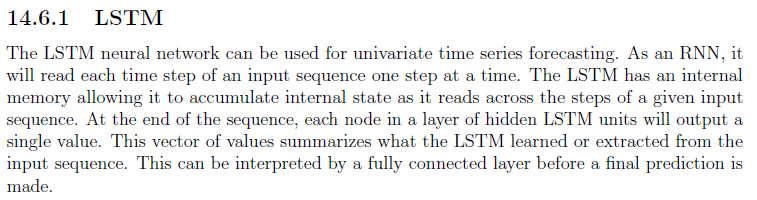

In [1]:
from IPython.display import Image
Image(".\pics\LSTM_forecast_fundament.PNG", width=3, height=5)

In [1]:
import tensorflow

tensorflow.__version__

'2.1.0'

In [2]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame, concat, read_csv
from sklearn.metrics import mean_squared_error
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from matplotlib import pyplot
import pandas as pd 

In [3]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = pd.read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)

,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [4]:
ev_sales_data.tail(5)

,BEV,sales
Date,,
2015-08-01,13121,12085
2015-09-01,15584,12736
2015-10-01,25107,11384
2015-11-01,60090,11402
2015-12-01,83500,16225


In [5]:
ev_sales_data['year'] = pd.Series(ev_sales_data.index).apply(lambda x: x.year).values
ev_sales_data['month'] = pd.Series(ev_sales_data.index).apply(lambda x: x.month).values
ev_sales_data.head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [12]:
def make_line_plots(title, dataset, attributes_to_plot=[], x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_colors=['red'],
                        x_axis_type=None, tools = "pan,wheel_zoom,box_zoom,reset"):
        try:
            from bokeh.plotting import figure, show, output_file
            from bokeh.models import HoverTool
            from bokeh.io import output_notebook

            output_notebook()

            p = figure(title=title, x_axis_type=x_axis_type, tools=tools, background_fill_color=background_color)
            p.legend.location = legend_location

            #x_values = dataset.index
            x_values = pd.to_datetime(dataset.index)
            i = 0
            for attribute in attributes_to_plot:
                    attribute_values = dataset[attribute]
                    p.line(x_values, attribute_values, legend=attribute, line_dash=[4, 4], line_color=line_colors[i], 
                            line_width=2)
                    i += 1


            p.y_range.start = 0
            p.legend.location = legend_location
            p.legend.background_fill_color = background_color
            p.xaxis.axis_label = x_axis_label
            p.yaxis.axis_label = y_axis_label
            p.grid.grid_line_color="white"

            p.add_tools(HoverTool())
            p.select_one(HoverTool).tooltips = [
                                    (x_axis_label, '@x'),
                                    (y_axis_label, '@y'),
                                ]
                                
            p.legend.click_policy="hide"

            show(p)

        except Exception as exc:
            return exc
            #logger.exception('raised exception at {}: {}'.format(logger.name+'.'+make_line_plots.__name__, exc))


In [13]:
make_line_plots('EV monthly sales', ev_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")



Loading BokehJS ...

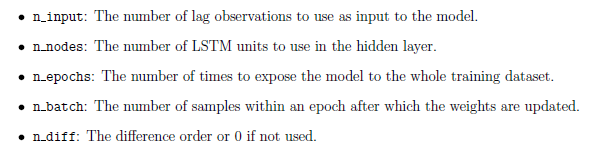

In [14]:
from IPython.display import Image
Image(".\pics\LSTM_TS_hyperparams.PNG", width=3, height=5)

In [9]:
DataFrame(ev_sales_data).head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [6]:
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

supervised_data = series_to_supervised(ev_sales_data['sales'], n_in=5, n_out=1)
supervised_data[0]

array([310., 417., 286., 162., 470., 273.])

In [7]:
DataFrame(supervised_data).head(6)

,0,1,2,3,4,5
0,310.0,417.0,286.0,162.0,470.0,273.0
1,417.0,286.0,162.0,470.0,273.0,650.0
2,286.0,162.0,470.0,273.0,650.0,1323.0
3,162.0,470.0,273.0,650.0,1323.0,688.0
4,470.0,273.0,650.0,1323.0,688.0,663.0
5,273.0,650.0,1323.0,688.0,663.0,896.0


In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-int(n_test)], data[-int(n_test):]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset TO MAKE THE SERIES STATIONARY:
'''
make the data stationary by performing a seasonal adjustment, that is subtracting the value
from one year ago from each observation.
'''
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


# fit a model
# el modelo regresivo se entrena sobre los datos diferenciados (serie estacionaria)
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

# forecast with a pre-fit model
# el modelo se entrenó sobre una serie histórica diferenciada (hecha estacionaria), y la predicción utiliza dicho modelo con datos input tb diferenciada, pero añadiendo la corrección al valor predicho al final 
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(data, n_test, config) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()



In [29]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [6, 30, 100, 100, 4]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

> 2565.137
 > 3101.526
 > 2595.702
 > 2652.089
 > 3284.597
 > 2604.626
 > 2848.246
 > 2875.797
 > 2459.394
 > 2300.609
 > 2866.690
 > 3237.467
 > 2700.200
 > 2502.867
 > 3281.380
 > 2105.140
 > 2929.064
 > 2538.014
 > 2734.903
 > 3007.462
 > 2225.537
 > 3065.580
 > 2628.142
 > 2864.430
 > 2246.473
 > 2984.323
 > 3551.206
 > 3141.138
 > 2983.398
 > 3005.310


LSTM: 3167.427 RMSE (+/- 267.766)


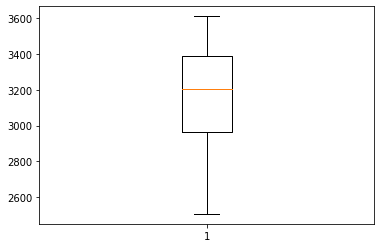

In [28]:
# summarize scores: n_diff = 4, CON DIFFERENCING
summarize_scores('LSTM', scores)

In [51]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [6, 30, 100, 100, 12]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)


> 3285.418
 > 2320.050
 > 2709.955
 > 3371.643
 > 3512.322
 > 3700.185
 > 3643.383
 > 4121.001
 > 2903.821
 > 2190.501
 > 3221.843
 > 5827.119
 > 3997.663
 > 3657.920
 > 2786.395
 > 3006.111
 > 2928.959
 > 2993.215
 > 1986.168
 > 3443.458
 > 3392.097
 > 6365.355
 > 2900.752
 > 3767.407
 > 2925.288
 > 3020.336
 > 1522.385
 > 2580.819
 > 2493.414
 > 2974.407


LSTM: 3251.646 RMSE (+/- 955.682)


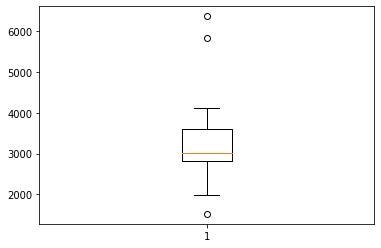

In [52]:
# summarize scores: n_diff = 12, CON DIFFERENCING ANUAL
summarize_scores('LSTM', scores)

LSTM: 2314.763 RMSE (+/- 495.052)


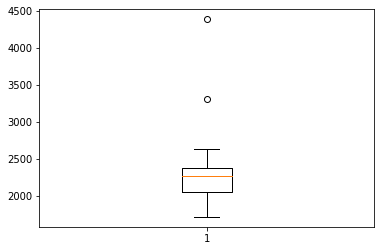

In [15]:
# summarize scores: n_diff = 0 SIN DIFFERENCING
summarize_scores('LSTM', scores)

In [25]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [10, 30, 100, 100, 4]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

> 2423.079
 > 2195.293
 > 3189.436
 > 2884.840
 > 3866.833
 > 2217.449
 > 2247.350
 > 3074.385
 > 5271.556
 > 2606.811
 > 1838.989
 > 2257.681
 > 2878.500
 > 3456.489
 > 2372.029
 > 2806.014
 > 2613.550
 > 2037.581
 > 2322.624
 > 2425.901
 > 3141.546
 > 2659.386
 > 2155.633
 > 2875.312
 > 2444.644
 > 2730.163
 > 2869.219
 > 2374.344
 > 2759.286
 > 3062.320


LSTM: 2735.275 RMSE (+/- 640.620)


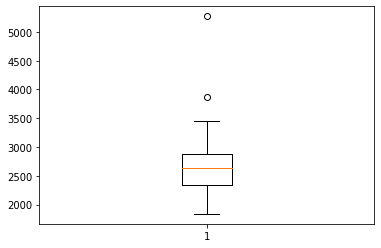

In [26]:
# summarize scores
summarize_scores('LSTM', scores)

In [42]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_LSTM_predictions'] = [x.numpy()[0] for x in predictions_matrix[-1]] #predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_LSTM_predictions
Date,,
2015-03-01,4079,5345.026855
2015-04-01,5730,8271.297852
2015-05-01,6354,2302.346436
2015-06-01,8308,6669.817871
2015-07-01,7338,4475.610840
2015-08-01,12085,8392.653320
2015-09-01,12736,7179.442871
2015-10-01,11384,9176.629883
2015-11-01,11402,8983.105469


In [43]:
make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_LSTM_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...

## COMPROBAR A HACER UNA MEJOR DIFFERENCING Y N_INPUT; JUGAR CON LA RELU  

HIPERPARAMETRIZO CON BAYESIAN TUNER

In [9]:
'''
First, we define a model-building function. It takes an argument hp from which you can sample hyperparameters, such as hp.Int('units', min_value=32, max_value=512, step=32) (an integer from a certain range).

This function returns a compiled model.
'''
from tensorflow import keras 
from kerastuner.tuners import RandomSearch, BayesianOptimization

n_input = 6
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model

# define model
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='timeseries_POCs_1',
    overwrite=True)


In [23]:
# walk-forward validation for univariate data
def walk_forward_validation(n_test, cfg, train, test, model):
    predictions = list()
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)

    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(n_test, config, train, test, model) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

In [10]:
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [10, None, 10, 100, 4]
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    bayesian_opt_tuner.search(train_x, train_y,
             epochs=n_epochs,
             #validation_data=(X_test, y_test)
             validation_split=0.2,verbose=1)
    #get best model
    bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
    model = bayes_opt_model_best_model[0]

    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

### Probamos a lanzar lo mismoq ue antes, pero incluyendo la bayesian hiperparam. para n_nodes de las hidden layers y el learning rate del optimizador

In [18]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff
config = [6, None, 100, 100, 4]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 40ms/sample - loss: 803185.3125 - mse: 803185.3125 - val_loss: 6726248.5000 - val_mse: 6726248.5000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 800630.6875 - mse: 800630.6875 - val_loss: 6713256.0000 - val_mse: 6713256.0000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 798352.8125 - mse: 798352.8125 - val_loss: 6704164.0000 - val_mse: 6704164.0000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 796261.9375 - mse: 796261.9375 - val_loss: 6697003.0000 - val_mse: 6697003.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 794198.6250 - mse: 794198.6250 - val_loss: 6691411.5000 - val_mse: 6691411.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 29ms/sample - loss: 784229.5625 - mse: 784229.5625 - val_loss: 6447673.0000 - val_mse: 6447673

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 30ms/sample - loss: 790727.8750 - mse: 790727.8750 - val_loss: 5149652.0000 - val_mse: 5149652.0000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 685829.8125 - mse: 685829.8125 - val_loss: 3997034.5000 - val_mse: 3997034.5000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 617777.5000 - mse: 617777.5000 - val_loss: 5131030.5000 - val_mse: 5131030.5000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 505764.8750 - mse: 505764.8750 - val_loss: 5660004.0000 - val_mse: 5660004.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 502870.6875 - mse: 502870.6875 - val_loss: 4595663.5000 - val_mse: 4595663.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 28ms/sample - loss: 785362.6875 - mse: 785362.6875 - val_loss: 5254762.0000 - val_mse: 5254762

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 30ms/sample - loss: 784145.0625 - mse: 784145.0625 - val_loss: 5900469.0000 - val_mse: 5900469.0000
Epoch 2/5
32/32 [==============================] - 0s 4ms/sample - loss: 777853.7500 - mse: 777853.7500 - val_loss: 5885005.0000 - val_mse: 5885005.0000
Epoch 3/5
32/32 [==============================] - 0s 4ms/sample - loss: 772051.3750 - mse: 772051.3750 - val_loss: 5892819.5000 - val_mse: 5892819.5000
Epoch 4/5
32/32 [==============================] - 0s 4ms/sample - loss: 766832.0625 - mse: 766832.0625 - val_loss: 5892854.0000 - val_mse: 5892854.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 762632.7500 - mse: 762632.7500 - val_loss: 5875870.5000 - val_mse: 5875870.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 27ms/sample - loss: 794343.4375 - mse: 794343.4375 - val_loss: 6523010.0000 - val_mse: 6523010

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 29ms/sample - loss: 792982.8125 - mse: 792982.8125 - val_loss: 5158529.0000 - val_mse: 5158529.0000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 700477.3750 - mse: 700477.3750 - val_loss: 4478150.0000 - val_mse: 4478150.0000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 627027.0000 - mse: 627027.0000 - val_loss: 4929255.0000 - val_mse: 4929255.0000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 563633.4375 - mse: 563633.4375 - val_loss: 4689413.0000 - val_mse: 4689413.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 510088.7812 - mse: 510088.7812 - val_loss: 5163593.5000 - val_mse: 5163593.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 26ms/sample - loss: 791308.2500 - mse: 791308.2500 - val_loss: 5706660.5000 - val_mse: 5706660

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 29ms/sample - loss: 786340.6250 - mse: 786340.6250 - val_loss: 4577429.5000 - val_mse: 4577429.5000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 685009.7500 - mse: 685009.7500 - val_loss: 3966392.0000 - val_mse: 3966392.0000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 618708.3750 - mse: 618708.3750 - val_loss: 5359283.5000 - val_mse: 5359283.5000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 565055.5625 - mse: 565055.5625 - val_loss: 5519219.5000 - val_mse: 5519219.5000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 551651.1250 - mse: 551651.1250 - val_loss: 4984472.0000 - val_mse: 4984472.0000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 26ms/sample - loss: 757850.3125 - mse: 757850.3125 - val_loss: 4541770.0000 - val_mse: 4541770

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 29ms/sample - loss: 768027.0625 - mse: 768027.0625 - val_loss: 5148622.0000 - val_mse: 5148622.0000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 702130.8750 - mse: 702130.8750 - val_loss: 4284774.5000 - val_mse: 4284774.5000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 629418.2500 - mse: 629418.2500 - val_loss: 4172104.2500 - val_mse: 4172104.2500
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 624182.1250 - mse: 624182.1250 - val_loss: 4527808.0000 - val_mse: 4527808.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 553833.0000 - mse: 553833.0000 - val_loss: 5079509.0000 - val_mse: 5079509.0000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 27ms/sample - loss: 813686.1250 - mse: 813686.1250 - val_loss: 5072532.0000 - val_mse: 5072532

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 30ms/sample - loss: 809148.8750 - mse: 809148.8750 - val_loss: 5062775.5000 - val_mse: 5062775.5000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 678216.5000 - mse: 678216.5000 - val_loss: 4187672.5000 - val_mse: 4187672.5000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 613991.5625 - mse: 613991.5625 - val_loss: 3826526.5000 - val_mse: 3826526.5000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 602420.3125 - mse: 602420.3125 - val_loss: 4541770.5000 - val_mse: 4541770.5000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 553946.6250 - mse: 553946.6250 - val_loss: 5321329.5000 - val_mse: 5321329.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 27ms/sample - loss: 805287.1250 - mse: 805287.1250 - val_loss: 5885382.0000 - val_mse: 5885382

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 30ms/sample - loss: 793861.7500 - mse: 793861.7500 - val_loss: 5043962.0000 - val_mse: 5043962.0000
Epoch 2/5
32/32 [==============================] - 0s 3ms/sample - loss: 696781.0000 - mse: 696781.0000 - val_loss: 4252388.0000 - val_mse: 4252388.0000
Epoch 3/5
32/32 [==============================] - 0s 3ms/sample - loss: 619611.6250 - mse: 619611.6250 - val_loss: 4417686.0000 - val_mse: 4417686.0000
Epoch 4/5
32/32 [==============================] - 0s 3ms/sample - loss: 585657.8750 - mse: 585657.8750 - val_loss: 5703532.0000 - val_mse: 5703532.0000
Epoch 5/5
32/32 [==============================] - 0s 3ms/sample - loss: 510359.1250 - mse: 510359.1250 - val_loss: 5321716.5000 - val_mse: 5321716.5000
Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 1s 27ms/sample - loss: 775673.6250 - mse: 775673.6250 - val_loss: 4699311.5000 - val_mse: 4699311

INFO:tensorflow:Oracle triggered exit
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939
 > 2194.939


LSTM: 2194.939 RMSE (+/- 0.000)


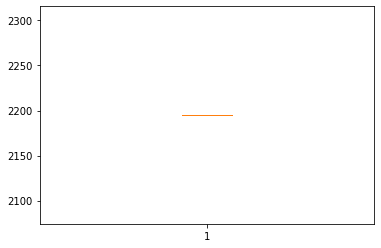

In [19]:
# summarize scores
summarize_scores('LSTM', scores)

In [20]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_LSTM_predictions'] = [x.numpy()[0] for x in predictions_matrix[-1]] #predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_LSTM_predictions
Date,,
2015-03-01,4079,5219.271484
2015-04-01,5730,7709.567871
2015-05-01,6354,4839.257324
2015-06-01,8308,8696.600586
2015-07-01,7338,5222.082520
2015-08-01,12085,9307.618164
2015-09-01,12736,11087.367188
2015-10-01,11384,15637.340820
2015-11-01,11402,9325.917969


In [21]:

make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_LSTM_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...

## Plotear los residuos para intuir si se puede mejorar el modelado

## Ahora testeo un modelo regresor clásico sobre la serie estacionarizada + aplicando la differencing a las predicciones 

In [64]:
sales_series_values = ev_sales_data['sales'].values
sales_series_values_diffed = difference(sales_series_values, 4)

ev_sales_data_diffed = ev_sales_data[4:]
ev_sales_data_diffed['sales'] = sales_series_values_diffed 

In [66]:

make_line_plots('EV monthly sales', ev_sales_data_diffed, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")


Loading BokehJS ...

### Hemos reducido mucho la tendencia (valores de escala en eje y) pero sigue no pareciendo estacionaria
### Vamos a repetir proceso aplicando logaritmo natural (en base *e*) junto a la anterior differencing a los valores para reducir el aparente crecimiento exponencial de los datos originales

In [67]:
from numpy import log

sales_series_values = ev_sales_data['sales'].values
sales_series_log_values = log(sales_series_values)
sales_series_log_values_diffed = difference(sales_series_log_values, 12)

ev_log_sales_data_diffed = ev_sales_data[12:]
ev_log_sales_data_diffed['sales'] = sales_series_log_values_diffed 


In [68]:
split = int(len(ev_log_sales_data_diffed) / 6)
X=ev_log_sales_data_diffed['sales']
X1, X2, X3, X4, X5, X6 = X[0:split], X[split:split*2], X[split*2:split*3], X[split*3:split*4], X[split*4:split*5], X[split*5:]

mean1, mean2, mean3, mean4, mean5, mean6 = X1.mean(), X2.mean(), X3.mean(), X4.mean(), X5.mean(), X6.mean()
var1, var2, var3, var4, var5, var6 = X1.var(), X2.var(), X3.var(), X4.var(), X5.var(), X6.var()
print('mean1=%f, mean2=%f, mean3=%f, mean4=%f, mean5=%f, mean6=%f' % (mean1, mean2, mean3, mean4, mean5, mean6))
print('variance1=%f, variance2=%f, variance3=%f, variance4=%f, variance5=%f, variance6=%f' % (var1, var2, var3, var4, var5, var6))

mean1=0.706748, mean2=0.407201, mean3=-2.599580, mean4=1.194522, mean5=3.196083, mean6=1.322963
variance1=0.466324, variance2=0.736127, variance3=5.690240, variance4=1.409850, variance5=5.515659, variance6=0.154014


In [69]:
make_line_plots('EV monthly sales', ev_log_sales_data_diffed, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")


Loading BokehJS ...

## Parece que hemos eliminado la tendencia; podemos decir que es estacionaria?

### Y solo con log sin diferenciar?

In [70]:
sales_series_values = ev_sales_data['sales'].values
sales_series_log_values = log(sales_series_values)

ev_log_sales_data = ev_sales_data
ev_log_sales_data['sales'] = sales_series_log_values 


In [71]:
split = int(len(ev_log_sales_data) / 6)
X=ev_log_sales_data['sales']
X1, X2, X3, X4, X5, X6 = X[0:split], X[split:split*2], X[split*2:split*3], X[split*3:split*4], X[split*4:split*5], X[split*5:]

mean1, mean2, mean3, mean4, mean5, mean6 = X1.mean(), X2.mean(), X3.mean(), X4.mean(), X5.mean(), X6.mean()
var1, var2, var3, var4, var5, var6 = X1.var(), X2.var(), X3.var(), X4.var(), X5.var(), X6.var()
print('mean1=%f, mean2=%f, mean3=%f, mean4=%f, mean5=%f, mean6=%f' % (mean1, mean2, mean3, mean4, mean5, mean6))
print('variance1=%f, variance2=%f, variance3=%f, variance4=%f, variance5=%f, variance6=%f' % (var1, var2, var3, var4, var5, var6))

mean1=6.097064, mean2=6.648557, mean3=6.747831, mean4=5.105479, mean5=8.013486, mean6=9.087744
variance1=0.363632, variance2=0.429449, variance3=0.677420, variance4=4.945168, variance5=0.366385, variance6=0.184706


In [72]:
make_line_plots('EV monthly sales', ev_log_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")


Loading BokehJS ...

## Aplico los modelados anteriores sobre estos datos, tanto con log aplicado como con log+diff

In [8]:
# difference dataset TO MAKE THE SERIES STATIONARY:
'''
make the data stationary by performing a seasonal adjustment, that is subtracting the value
from one year ago from each observation.
'''
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


# fit a model
# el modelo regresivo se entrena sobre los datos diferenciados (serie estacionaria)
def model_fit(train, config):
    from numpy import log
    
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log = config
    # prepare data

    if apply_log:
        train = log(train)
        
    if n_diff > 0:
        train = difference(train, n_diff)

    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

# forecast with a pre-fit model
# el modelo se entrenó sobre una serie histórica diferenciada (hecha estacionaria), y la predicción utiliza dicho modelo con datos input tb diferenciada, pero añadiendo la corrección al valor predicho al final 
def model_predict(model, history, config):
    from numpy import log, exp
    # unpack config
    n_input, _, _, _, n_diff, apply_log = config
    # prepare data

    if apply_log: #aplicamos la misma transformación que al entrenar
        history = log(history)

    correction = 0.0
    if n_diff > 0: #aplicamos la misma transformación que al entrenar
        correction_diff = history[-n_diff]
        history = difference(history, n_diff)

    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    
    if apply_log:
        return correction + exp(yhat[0]) 

    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(data, n_test, config) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

def get_not_nan_from_array(my_array):
    import numpy as np
    
    not_nan_mask = np.isnan(my_array)==False
  
    return my_array[not_nan_mask] 

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    #actual = get_not_nan_from_array(actual)
    #print('actual: ', actual)
    #predicted = get_not_nan_from_array(predicted)
    #print('predicted: ', predicted)

    return sqrt(mean_squared_error(actual, predicted))


actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([6241.778], dtype=float32), array([6425.515], dtype=float32), array([7388.3345], dtype=float32), array([7685.3784], dtype=float32), array([7433.8364], dtype=float32), array([9066.286], dtype=float32), array([9536.1455], dtype=float32), array([12092.988], dtype=float32), array([14346.077], dtype=float32), array([16893.77], dtype=float32)]
 > 1886.723
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([5793.4487], dtype=float32), array([5801.7036], dtype=float32), array([6671.641], dtype=float32), array([7135.9385], dtype=float32), array([6742.7695], dtype=float32), array([8314.045], dtype=float32), array([8709.654], dtype=float32), array([10948.761], dtype=float32), array([12723.127], dtype=float32), array([14763.323], dtype=float32)]
 > 1981.824
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([5469.493], dtype=float32), array([58

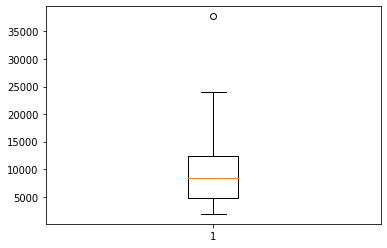

In [96]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 0, True]
# grid search
#scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

LSTM: 10960.013 RMSE (+/- 8377.212)


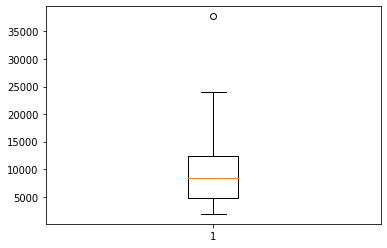

In [97]:
# summarize scores
summarize_scores('LSTM', scores)

In [99]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_LSTM_predictions'] = [x[0] for x in predictions_matrix[-1]] #predictions_matrix[-1]

ev_sales_forecast_df

make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_LSTM_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([14056.234], dtype=float32), array([13111.963], dtype=float32), array([16230.846], dtype=float32), array([17574.566], dtype=float32), array([18462.832], dtype=float32), array([22575.705], dtype=float32), array([27863.293], dtype=float32), array([37128.44], dtype=float32), array([44252.035], dtype=float32), array([52696.38], dtype=float32)]


Loading BokehJS ...

### Y metiendo differencing + log?

actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([1.0403007], dtype=float32), array([62184.133], dtype=float32), array([68357.945], dtype=float32)]
 > 24386.655
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([1.0468506], dtype=float32), array([61272.043], dtype=float32), array([70435.5], dtype=float32)]
 > 24649.988
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([1.0303924], dtype=float32), a

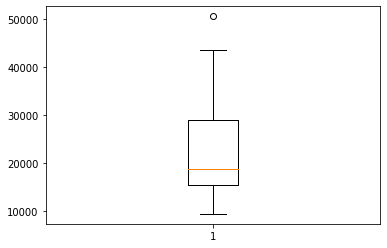

In [100]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 4, True]
# grid search
#scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

LSTM: 22443.347 RMSE (+/- 10264.668)


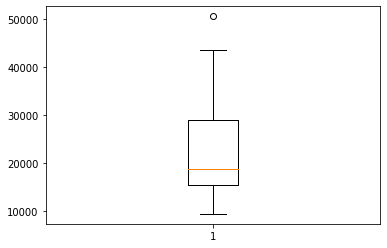

In [101]:
# summarize scores
summarize_scores('LSTM', scores)

## Errores muy altos, pruebo a representar gráficamente los efectos aplicados

In [112]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)

,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [113]:
sales_series_values = ev_sales_data['sales'].values
sales_series_log_values = log(sales_series_values)

ev_log_sales_data = ev_sales_data
ev_log_sales_data['sales'] = sales_series_log_values 

sales_series_values_diffed_log = difference(sales_series_log_values, 5)
ev_sales_data_diffed_log = ev_log_sales_data[5:]
ev_sales_data_diffed_log['sales'] = sales_series_values_diffed_log 

make_line_plots('EV monthly sales', ev_sales_data_diffed_log, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")


Loading BokehJS ...

In [114]:
split = int(len(ev_sales_data_diffed_log) / 6)
X=ev_sales_data_diffed_log['sales']
X1, X2, X3, X4, X5, X6 = X[0:split], X[split:split*2], X[split*2:split*3], X[split*3:split*4], X[split*4:split*5], X[split*5:]

mean1, mean2, mean3, mean4, mean5, mean6 = X1.mean(), X2.mean(), X3.mean(), X4.mean(), X5.mean(), X6.mean()
var1, var2, var3, var4, var5, var6 = X1.var(), X2.var(), X3.var(), X4.var(), X5.var(), X6.var()
print('mean1=%f, mean2=%f, mean3=%f, mean4=%f, mean5=%f, mean6=%f' % (mean1, mean2, mean3, mean4, mean5, mean6))
print('variance1=%f, variance2=%f, variance3=%f, variance4=%f, variance5=%f, variance6=%f' % (var1, var2, var3, var4, var5, var6))

mean1=0.259545, mean2=0.656398, mean3=-0.877537, mean4=0.565504, mean5=0.886802, mean6=0.514533
variance1=1.136778, variance2=0.409336, variance3=0.711010, variance4=17.181576, variance5=0.266718, variance6=0.150196


actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([4690.0137], dtype=float32), array([3574.7488], dtype=float32), array([3578.9272], dtype=float32), array([1.0431188], dtype=float32), array([1.0431188], dtype=float32), array([1.0431188], dtype=float32), array([1.0431188], dtype=float32), array([1.0431188], dtype=float32), array([1.0431188], dtype=float32), array([10648.865], dtype=float32)]
 > 8569.737
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([9383.038], dtype=float32), array([5796.135], dtype=float32), array([6485.4043], dtype=float32), array([1.0642257], dtype=float32), array([1.0642257], dtype=float32), array([1.0642257], dtype=float32), array([1.0642257], dtype=float32), array([1.0642257], dtype=float32), array([1.0642257], dtype=float32), array([28417.184], dtype=float32)]
 > 9313.390
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([4102.372], dtype=float32), arra

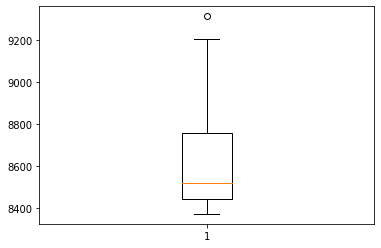

In [115]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 5, True]
# grid search
#scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

## VS sin log

actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([12318.962], dtype=float32), array([6604.482], dtype=float32), array([10780.285], dtype=float32), array([4411.2217], dtype=float32), array([5868.674], dtype=float32), array([8293.142], dtype=float32), array([8069.286], dtype=float32), array([10820.645], dtype=float32), array([11697.764], dtype=float32), array([14127.287], dtype=float32)]
 > 3828.304
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([7392.9614], dtype=float32), array([6254.64], dtype=float32), array([8175.1216], dtype=float32), array([8039.3506], dtype=float32), array([7549.977], dtype=float32), array([8564.979], dtype=float32), array([7853.3906], dtype=float32), array([10087.87], dtype=float32), array([11878.944], dtype=float32), array([12489.859], dtype=float32)]
 > 2584.189
actual:[ 4079  5730  6354  8308  7338 12085 12736 11384 11402 16225]
predicted:[array([7726.1113], dtype=float32), array([408

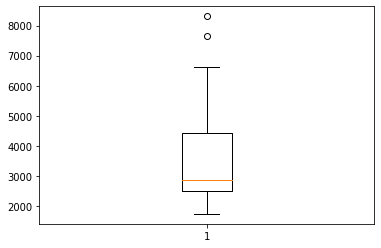

In [119]:
# data split
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 12, False]
# grid search
#scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

LSTM: 3675.630 RMSE (+/- 1729.108)


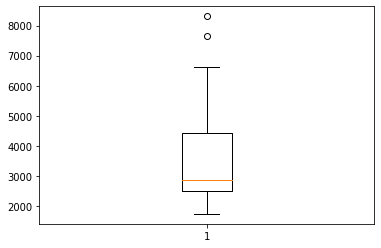

In [120]:
# summarize scores
summarize_scores('LSTM', scores)

> 10215.758
 > 10215.821
 > 10215.818
 > 10215.824
 > 10215.719
 > 10215.746
 > 10215.813
 > 10215.796
 > 10215.760
 > 10215.727
 > 10215.808
 > 10215.703
 > 10215.760
 > 10215.779
 > 10215.757
 > 10215.716
 > 10215.762
 > 10215.744
 > 10215.810
 > 10215.791
 > 10215.818
 > 10215.845
 > 10215.760
 > 10215.834
 > 10215.778
 > 10215.793
 > 10215.764
 > 10215.820
 > 10215.773
 > 10215.853
LSTM: 10215.782 RMSE (+/- 0.039)


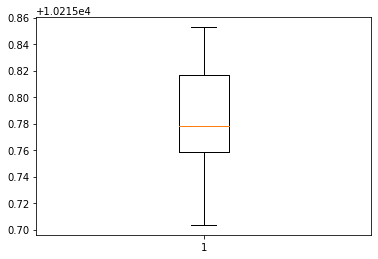

In [124]:
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 5, True]
# grid search
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

> 2175.770
 > 2117.685
 > 2708.148
 > 1915.430
 > 6164.692
 > 2121.478
 > 2124.097
 > 2463.985
 > 2678.948
 > 2941.520
 > 2167.443
 > 2078.829
 > 1564.839
 > 2613.212
 > 1999.598
 > 1665.045
 > 3758.339
 > 1917.320
 > 1963.351
 > 2134.169
 > 2064.601
 > 2516.781
 > 2110.966
 > 2286.581
 > 2005.669
 > 2582.918
 > 2584.112
 > 1733.149
 > 2647.899
 > 3487.951
LSTM: 2443.151 RMSE (+/- 840.255)


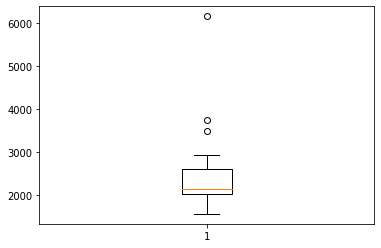

In [126]:
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff, apply_log
config = [6, 30, 100, 100, 0, False]
# grid search
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

### Según esto, mejor entrenar la red sin log ni differencing

In [9]:
from kerastuner.tuners import RandomSearch, BayesianOptimization

'''
First, we define a model-building function. It takes an argument hp from which you can sample hyperparameters, such as hp.Int('units', min_value=32, max_value=512, step=32) (an integer from a certain range).

This function returns a compiled model.
'''
from tensorflow import keras 

n_input = 6
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model

# define model
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=8,
    executions_per_trial=2,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='timeseries_POCs_evsalesdata_noDiff_noLog',
    overwrite=True)


# walk-forward validation for univariate data
def walk_forward_validation(n_test, cfg, train, test, model):
    predictions = list()
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)

    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(n_test, config, train, test, model) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix


def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    bayesian_opt_tuner.search(train_x, train_y,
             epochs=n_epochs,
             #validation_data=(X_test, y_test)
             validation_split=0.2,verbose=1)
    #get best model
    bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
    model = bayes_opt_model_best_model[0]

    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

def model_predict(model, history, config):
    # unpack config
    n_diff = config[-1]
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]


In [19]:
n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff #, apply_log
config = [6, None, 100, 100, 0]
# grid search
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM', scores)

00
Epoch 19/100
32/35 [==========================>...] - ETA: 0s - loss: 578685.1875 - mse: 578685.18735/35 [==============================] - 0s 741us/sample - loss: 583637.1107 - mse: 583637.0625 - val_loss: 8200752.0000 - val_mse: 8200752.0000
Epoch 20/100
32/35 [==========================>...] - ETA: 0s - loss: 538278.1875 - mse: 538278.18735/35 [==============================] - 0s 741us/sample - loss: 552706.4571 - mse: 552706.4375 - val_loss: 7740457.0000 - val_mse: 7740457.0000
Epoch 21/100
32/35 [==========================>...] - ETA: 0s - loss: 534054.8750 - mse: 534054.87535/35 [==============================] - 0s 627us/sample - loss: 523871.4580 - mse: 523871.4375 - val_loss: 7220447.0000 - val_mse: 7220447.0000
Epoch 22/100
32/35 [==========================>...] - ETA: 0s - loss: 539287.1875 - mse: 539287.18735/35 [==============================] - 0s 655us/sample - loss: 498540.1653 - mse: 498540.1562 - val_loss: 6866396.0000 - val_mse: 6866396.0000
Epoch 23/100
32/35 [=

100
32/35 [==========================>...] - ETA: 0s - loss: 381441.8750 - mse: 381441.87535/35 [==============================] - 0s 627us/sample - loss: 356785.2018 - mse: 356785.1875 - val_loss: 2487454.0000 - val_mse: 2487454.0000
Epoch 20/100
32/35 [==========================>...] - ETA: 0s - loss: 368533.2812 - mse: 368533.28135/35 [==============================] - 0s 627us/sample - loss: 351503.8254 - mse: 351503.8438 - val_loss: 2414625.2500 - val_mse: 2414625.2500
Epoch 21/100
32/35 [==========================>...] - ETA: 0s - loss: 363105.2500 - mse: 363105.25035/35 [==============================] - 0s 783us/sample - loss: 346277.4183 - mse: 346277.4375 - val_loss: 2472265.5000 - val_mse: 2472265.5000
Epoch 22/100
32/35 [==========================>...] - ETA: 0s - loss: 357336.1875 - mse: 357336.18735/35 [==============================] - 0s 655us/sample - loss: 346083.8156 - mse: 346083.8438 - val_loss: 2481080.2500 - val_mse: 2481080.2500
Epoch 23/100
32/35 [=============

oss: 947511.6250 - mse: 947511.62535/35 [==============================] - 0s 627us/sample - loss: 964866.3357 - mse: 964866.3125 - val_loss: 13724023.0000 - val_mse: 13724023.0000
Epoch 20/100
32/35 [==========================>...] - ETA: 0s - loss: 762637.7500 - mse: 762637.75035/35 [==============================] - 0s 627us/sample - loss: 956058.5714 - mse: 956058.5625 - val_loss: 13551586.0000 - val_mse: 13551586.0000
Epoch 21/100
32/35 [==========================>...] - ETA: 0s - loss: 781890.7500 - mse: 781890.75035/35 [==============================] - 0s 598us/sample - loss: 947299.9286 - mse: 947299.9375 - val_loss: 13332084.0000 - val_mse: 13332084.0000
Epoch 22/100
32/35 [==========================>...] - ETA: 0s - loss: 889376.6250 - mse: 889376.62535/35 [==============================] - 0s 628us/sample - loss: 939049.5107 - mse: 939049.5000 - val_loss: 13189948.0000 - val_mse: 13189948.0000
Epoch 23/100
32/35 [==========================>...] - ETA: 0s - loss: 930723.6250

100
32/35 [==========================>...] - ETA: 0s - loss: 871151.6250 - mse: 871151.62535/35 [==============================] - 0s 742us/sample - loss: 799178.3499 - mse: 799178.3125 - val_loss: 11751767.0000 - val_mse: 11751767.0000
Epoch 20/100
32/35 [==========================>...] - ETA: 0s - loss: 669952.7500 - mse: 669952.75035/35 [==============================] - 0s 655us/sample - loss: 776081.5964 - mse: 776081.6250 - val_loss: 11481324.0000 - val_mse: 11481324.0000
Epoch 21/100
32/35 [==========================>...] - ETA: 0s - loss: 742067.8750 - mse: 742067.87535/35 [==============================] - 0s 712us/sample - loss: 754179.9786 - mse: 754180.0000 - val_loss: 11181380.0000 - val_mse: 11181380.0000
Epoch 22/100
32/35 [==========================>...] - ETA: 0s - loss: 704814.7500 - mse: 704814.75035/35 [==============================] - 0s 627us/sample - loss: 731241.5571 - mse: 731241.5625 - val_loss: 10885003.0000 - val_mse: 10885003.0000
Epoch 23/100
32/35 [=====

22098.0000
Epoch 19/100
32/35 [==========================>...] - ETA: 0s - loss: 934891.1250 - mse: 934891.12535/35 [==============================] - 0s 598us/sample - loss: 910206.7232 - mse: 910206.7500 - val_loss: 13039953.0000 - val_mse: 13039953.0000
Epoch 20/100
32/35 [==========================>...] - ETA: 0s - loss: 910471.5625 - mse: 910471.56235/35 [==============================] - 0s 655us/sample - loss: 887704.7929 - mse: 887704.8125 - val_loss: 12728969.0000 - val_mse: 12728969.0000
Epoch 21/100
32/35 [==========================>...] - ETA: 0s - loss: 856686.2500 - mse: 856686.25035/35 [==============================] - 0s 655us/sample - loss: 865126.9643 - mse: 865127.0000 - val_loss: 12419480.0000 - val_mse: 12419480.0000
Epoch 22/100
32/35 [==========================>...] - ETA: 0s - loss: 886792.7500 - mse: 886792.75035/35 [==============================] - 0s 712us/sample - loss: 842440.8786 - mse: 842440.8750 - val_loss: 12098466.0000 - val_mse: 12098466.0000
Epoch

Train on 35 samples, validate on 9 samples
Epoch 1/100
32/35 [==========================>...] - ETA: 0s - loss: 1123842.2500 - mse: 1123842.25035/35 [==============================] - 1s 35ms/sample - loss: 1139710.6000 - mse: 1139710.6250 - val_loss: 16126880.0000 - val_mse: 16126880.0000
Epoch 2/100
32/35 [==========================>...] - ETA: 0s - loss: 1132726.2500 - mse: 1132726.25035/35 [==============================] - 0s 3ms/sample - loss: 1112269.5714 - mse: 1112269.6250 - val_loss: 15820032.0000 - val_mse: 15820032.0000
Epoch 3/100
32/35 [==========================>...] - ETA: 0s - loss: 1032212.5000 - mse: 1032212.50035/35 [==============================] - 0s 3ms/sample - loss: 1087856.7893 - mse: 1087856.7500 - val_loss: 15415488.0000 - val_mse: 15415488.0000
Epoch 4/100
32/35 [==========================>...] - ETA: 0s - loss: 1036959.3750 - mse: 1036959.37535/35 [==============================] - 0s 3ms/sample - loss: 1063732.4464 - mse: 1063732.5000 - val_loss: 1511675

Emplear el walk-forward también para esta LSTM!

In [33]:
from tensorflow import keras 
from kerastuner.tuners import BayesianOptimization

n_input = 6
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), 
                   activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                        max_value=512,
                                        step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])))

    return model

def model_search_and_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

    bayesian_opt_tuner = BayesianOptimization(
        build_model,
        objective='mse',
        max_trials=8,
        executions_per_trial=2,
        directory=os.path.normpath('C:/keras_tuning'),
        project_name='timeseries_POCs_evsalesdata_noDiff_noLog',
        overwrite=True)

    bayesian_opt_tuner.search(train_x, train_y,
             epochs=n_epochs,
             #validation_data=(X_test, y_test)
             validation_split=0.2,verbose=1)
    #get best model
    bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
    model = bayes_opt_model_best_model[0]

    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

def model_predict(model, history, config):
    # unpack config
    n_diff = config[-1]
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

def walk_forward_validation(n_test, cfg, train_data):
    predictions = list()
    # split dataset
    train, test = train_test_split(train_data, n_test)

    # fit model
    model = model_search_and_fit(train, cfg)

    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, n_test, config, n_repeats=5):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # split dataset
    train, test = train_test_split(data, config[3])
    # fit model
    #model = model_fit(train, config)

    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(config[3], config, train) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix


In [34]:
#n_test = 10 #int(0.1*len(sales_series_values))
# define config: n_input, n_nodes, n_epochs, n_batch, n_diff #, apply_log
config = [6, None, 2, int(0.9*len(sales_series_values)), 0]
# grid search
scores, predictions_matrix = repeat_evaluate(sales_series_values, n_test, config)

Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1328673.1250 - mse: 1328673.1250 - val_loss: 631508.6250 - val_mse: 631508.6250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 520422.7812 - mse: 520422.7812 - val_loss: 478614.8125 - val_mse: 478614.8125
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1147481.6250 - mse: 1147481.6250 - val_loss: 575733.0000 - val_mse: 575733.0000
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 503025.0312 - mse: 503025.0312 - val_loss: 542761.3125 - val_mse: 542761.3125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1180712.1250 - mse: 1180712.1250 - val_loss: 841038.1250 - val_mse: 841038.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1029272.4375 - mse: 1029272.4375 - val_loss: 795980.9375 - val_mse: 795980.9375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1273429.8750 - mse: 1273429.8750 - val_loss: 861636.1875 - val_mse: 861636.1875
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 1150847.7500 - mse: 1150847.7500 - val_loss: 825088.6875 - val_mse: 825088.6875


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 1186030.5000 - mse: 1186030.5000 - val_loss: 828894.3125 - val_mse: 828894.3125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1079245.5000 - mse: 1079245.5000 - val_loss: 796580.5000 - val_mse: 796580.5000
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1442535.8750 - mse: 1442535.8750 - val_loss: 905710.0000 - val_mse: 905710.0000
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 1310898.8750 - mse: 1310898.8750 - val_loss: 864196.3125 - val_mse: 864196.3125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1114427.6250 - mse: 1114427.6250 - val_loss: 817952.8125 - val_mse: 817952.8125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1016329.5000 - mse: 1016329.5000 - val_loss: 782198.0625 - val_mse: 782198.0625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 36ms/sample - loss: 1194347.3750 - mse: 1194347.3750 - val_loss: 828434.1250 - val_mse: 828434.1250
Epoch 2/2
27/27 [==============================] - 0s 628us/sample - loss: 1079259.5000 - mse: 1079259.5000 - val_loss: 789666.8750 - val_mse: 789666.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1254717.5000 - mse: 1254717.5000 - val_loss: 818169.8125 - val_mse: 818169.8125
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1019871.4375 - mse: 1019871.4375 - val_loss: 762589.9375 - val_mse: 762589.9375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1169692.0000 - mse: 1169692.0000 - val_loss: 804692.4375 - val_mse: 804692.4375
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1006751.1250 - mse: 1006751.1250 - val_loss: 749551.0625 - val_mse: 749551.0625


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 1292854.5000 - mse: 1292854.5000 - val_loss: 911336.5000 - val_mse: 911336.5000
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1286053.5000 - mse: 1286053.5000 - val_loss: 909960.1250 - val_mse: 909960.1250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 1091953.6250 - mse: 1091953.6250 - val_loss: 836449.1875 - val_mse: 836449.1875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1083353.3750 - mse: 1083353.3750 - val_loss: 833726.6875 - val_mse: 833726.6875


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1159970.8750 - mse: 1159970.8750 - val_loss: 812618.5625 - val_mse: 812618.5625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 996599.6875 - mse: 996599.6875 - val_loss: 760848.3750 - val_mse: 760848.3750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1167293.7500 - mse: 1167293.7500 - val_loss: 815284.4375 - val_mse: 815284.4375
Epoch 2/2
27/27 [==============================] - 0s 480us/sample - loss: 1036613.0625 - mse: 1036613.0625 - val_loss: 778372.3750 - val_mse: 778372.3750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1109339.0000 - mse: 1109339.0000 - val_loss: 546673.0000 - val_mse: 546673.0000
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 443844.0000 - mse: 443844.0000 - val_loss: 508286.7812 - val_mse: 508286.7812
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1142336.2500 - mse: 1142336.2500 - val_loss: 584199.0625 - val_mse: 584199.0625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 435250.4062 - mse: 435250.4062 - val_loss: 410740.5000 - val_mse: 410740.5000


INFO:tensorflow:Oracle triggered exit
 > 2317.887
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1058721.6250 - mse: 1058721.6250 - val_loss: 502289.4688 - val_mse: 502289.4688
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 724769.1875 - mse: 724769.1875 - val_loss: 742289.3750 - val_mse: 742289.3750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1377911.5000 - mse: 1377911.5000 - val_loss: 633048.5625 - val_mse: 633048.5625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 473687.5312 - mse: 473687.5312 - val_loss: 513864.4062 - val_mse: 513864.4062


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1134435.8750 - mse: 1134435.8750 - val_loss: 854779.8750 - val_mse: 854779.8750
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1101032.5000 - mse: 1101032.5000 - val_loss: 848194.5625 - val_mse: 848194.5625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1150824.6250 - mse: 1150824.6250 - val_loss: 851534.8750 - val_mse: 851534.8750
Epoch 2/2
27/27 [==============================] - 0s 628us/sample - loss: 1122108.6250 - mse: 1122108.6250 - val_loss: 844351.4375 - val_mse: 844351.4375


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1204031.2500 - mse: 1204031.2500 - val_loss: 1582180.8750 - val_mse: 1582180.8750
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 6460319.0000 - mse: 6460319.0000 - val_loss: 587221.3125 - val_mse: 587221.3125
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 930426.5000 - mse: 930426.5000 - val_loss: 765600.3750 - val_mse: 765600.3750
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 4216618.0000 - mse: 4216618.0000 - val_loss: 589518.3750 - val_mse: 589518.3750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1316439.7500 - mse: 1316439.7500 - val_loss: 751098.0000 - val_mse: 751098.0000
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 864091.5000 - mse: 864091.5000 - val_loss: 650830.6250 - val_mse: 650830.6250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1243397.0000 - mse: 1243397.0000 - val_loss: 775200.3750 - val_mse: 775200.3750
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 882892.4375 - mse: 882892.4375 - val_loss: 633216.6250 - val_mse: 633216.6250


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1061297.8750 - mse: 1061297.8750 - val_loss: 819258.1250 - val_mse: 819258.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1026936.3125 - mse: 1026936.3125 - val_loss: 806752.1250 - val_mse: 806752.1250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1267681.5000 - mse: 1267681.5000 - val_loss: 865954.5625 - val_mse: 865954.5625
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 1203019.5000 - mse: 1203019.5000 - val_loss: 848181.5625 - val_mse: 848181.5625


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1245634.1250 - mse: 1245634.1250 - val_loss: 863346.3750 - val_mse: 863346.3750
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1127502.6250 - mse: 1127502.6250 - val_loss: 832239.0625 - val_mse: 832239.0625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1172747.1250 - mse: 1172747.1250 - val_loss: 846049.3125 - val_mse: 846049.3125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1092299.3750 - mse: 1092299.3750 - val_loss: 822981.8750 - val_mse: 822981.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1240235.7500 - mse: 1240235.7500 - val_loss: 539667.6250 - val_mse: 539667.6250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 452967.1562 - mse: 452967.1562 - val_loss: 547528.0625 - val_mse: 547528.0625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1197291.8750 - mse: 1197291.8750 - val_loss: 547445.3125 - val_mse: 547445.3125
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 458826.5938 - mse: 458826.5938 - val_loss: 572403.8750 - val_mse: 572403.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1216147.2500 - mse: 1216147.2500 - val_loss: 510212.2812 - val_mse: 510212.2812
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 2378057.2500 - mse: 2378057.2500 - val_loss: 649345.8750 - val_mse: 649345.8750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1343567.0000 - mse: 1343567.0000 - val_loss: 699006.6250 - val_mse: 699006.6250
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 787192.3125 - mse: 787192.3125 - val_loss: 522266.4062 - val_mse: 522266.4062


INFO:tensorflow:Oracle triggered exit
 > 1691.019
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 43ms/sample - loss: 1267484.5000 - mse: 1267484.5000 - val_loss: 607801.4375 - val_mse: 607801.4375
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 539826.2500 - mse: 539826.2500 - val_loss: 459529.7812 - val_mse: 459529.7812
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 1257243.5000 - mse: 1257243.5000 - val_loss: 557965.6250 - val_mse: 557965.6250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 476689.4688 - mse: 476689.4688 - val_loss: 633955.5625 - val_mse: 633955.5625


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1257641.3750 - mse: 1257641.3750 - val_loss: 1397073.2500 - val_mse: 1397073.2500
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 6169815.5000 - mse: 6169815.5000 - val_loss: 696313.6250 - val_mse: 696313.6250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1239198.8750 - mse: 1239198.8750 - val_loss: 1444329.1250 - val_mse: 1444329.1250
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 5671884.5000 - mse: 5671884.5000 - val_loss: 699643.1250 - val_mse: 699643.1250


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1289430.8750 - mse: 1289430.8750 - val_loss: 546161.1875 - val_mse: 546161.1875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 437252.0000 - mse: 437252.0000 - val_loss: 459671.0625 - val_mse: 459671.0625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1169402.0000 - mse: 1169402.0000 - val_loss: 946142.5625 - val_mse: 946142.5625
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 3372008.2500 - mse: 3372008.2500 - val_loss: 671676.3125 - val_mse: 671676.3125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1138398.2500 - mse: 1138398.2500 - val_loss: 829948.6875 - val_mse: 829948.6875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1072475.1250 - mse: 1072475.1250 - val_loss: 808383.0000 - val_mse: 808383.0000
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1058371.7500 - mse: 1058371.7500 - val_loss: 804429.6875 - val_mse: 804429.6875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 944923.4375 - mse: 944923.4375 - val_loss: 765561.5625 - val_mse: 765561.5625


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1262992.0000 - mse: 1262992.0000 - val_loss: 689279.1250 - val_mse: 689279.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 988508.0000 - mse: 988508.0000 - val_loss: 669824.8125 - val_mse: 669824.8125
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1132717.5000 - mse: 1132717.5000 - val_loss: 676088.6250 - val_mse: 676088.6250
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 1770237.1250 - mse: 1770237.1250 - val_loss: 727880.4375 - val_mse: 727880.4375


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1330253.1250 - mse: 1330253.1250 - val_loss: 872121.1250 - val_mse: 872121.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1217975.5000 - mse: 1217975.5000 - val_loss: 835822.3125 - val_mse: 835822.3125
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1129301.3750 - mse: 1129301.3750 - val_loss: 795960.5625 - val_mse: 795960.5625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 945431.6250 - mse: 945431.6250 - val_loss: 750045.8750 - val_mse: 750045.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1112700.6250 - mse: 1112700.6250 - val_loss: 2789584.0000 - val_mse: 2789584.0000
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 14852501.0000 - mse: 14852501.0000 - val_loss: 647271.1250 - val_mse: 647271.1250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1197178.6250 - mse: 1197178.6250 - val_loss: 1603043.1250 - val_mse: 1603043.1250
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 6711320.5000 - mse: 6711320.5000 - val_loss: 700726.1875 - val_mse: 700726.1875


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1300469.8750 - mse: 1300469.8750 - val_loss: 531028.4375 - val_mse: 531028.4375
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 496538.2500 - mse: 496538.2500 - val_loss: 446054.4375 - val_mse: 446054.4375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1417168.2500 - mse: 1417168.2500 - val_loss: 591354.1875 - val_mse: 591354.1875
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 507616.2812 - mse: 507616.2812 - val_loss: 545973.3750 - val_mse: 545973.3750


INFO:tensorflow:Oracle triggered exit
 > 2096.954
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1303390.3750 - mse: 1303390.3750 - val_loss: 861801.0000 - val_mse: 861801.0000
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1190579.5000 - mse: 1190579.5000 - val_loss: 836312.0625 - val_mse: 836312.0625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1193438.8750 - mse: 1193438.8750 - val_loss: 838743.0625 - val_mse: 838743.0625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1125103.8750 - mse: 1125103.8750 - val_loss: 813968.8750 - val_mse: 813968.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1202610.0000 - mse: 1202610.0000 - val_loss: 2265741.5000 - val_mse: 2265741.5000
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 10195116.0000 - mse: 10195116.0000 - val_loss: 695139.9375 - val_mse: 695139.9375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1207907.8750 - mse: 1207907.8750 - val_loss: 1617151.3750 - val_mse: 1617151.3750
Epoch 2/2
27/27 [==============================] - 0s 516us/sample - loss: 7599925.5000 - mse: 7599925.5000 - val_loss: 662266.5000 - val_mse: 662266.5000


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1210103.5000 - mse: 1210103.5000 - val_loss: 869125.0625 - val_mse: 869125.0625
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1185625.0000 - mse: 1185625.0000 - val_loss: 863868.0000 - val_mse: 863868.0000
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1129785.7500 - mse: 1129785.7500 - val_loss: 842745.5000 - val_mse: 842745.5000
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1085679.1250 - mse: 1085679.1250 - val_loss: 833788.3125 - val_mse: 833788.3125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1158206.8750 - mse: 1158206.8750 - val_loss: 2374555.7500 - val_mse: 2374555.7500
Epoch 2/2
27/27 [==============================] - 0s 554us/sample - loss: 10173097.0000 - mse: 10173097.0000 - val_loss: 695545.3750 - val_mse: 695545.3750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1254962.6250 - mse: 1254962.6250 - val_loss: 841827.0000 - val_mse: 841827.0000
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 3372428.7500 - mse: 3372428.7500 - val_loss: 733844.1250 - val_mse: 733844.1250


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1237419.8750 - mse: 1237419.8750 - val_loss: 483891.2188 - val_mse: 483891.2188
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 721448.0625 - mse: 721448.0625 - val_loss: 616746.4375 - val_mse: 616746.4375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1257505.7500 - mse: 1257505.7500 - val_loss: 585639.5625 - val_mse: 585639.5625
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 537839.8125 - mse: 537839.8125 - val_loss: 672210.6875 - val_mse: 672210.6875


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1753489.1250 - mse: 1753489.1250 - val_loss: 1020943.1250 - val_mse: 1020943.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1742824.0000 - mse: 1742824.0000 - val_loss: 1019328.0000 - val_mse: 1019328.0000
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1534530.6250 - mse: 1534530.6250 - val_loss: 958641.8750 - val_mse: 958641.8750
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1529383.5000 - mse: 1529383.5000 - val_loss: 957747.3125 - val_mse: 957747.3125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1472471.0000 - mse: 1472471.0000 - val_loss: 902487.4375 - val_mse: 902487.4375
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1340115.0000 - mse: 1340115.0000 - val_loss: 861126.4375 - val_mse: 861126.4375
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1147996.1250 - mse: 1147996.1250 - val_loss: 830746.3125 - val_mse: 830746.3125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1070974.2500 - mse: 1070974.2500 - val_loss: 809266.8750 - val_mse: 809266.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1188900.2500 - mse: 1188900.2500 - val_loss: 852959.3125 - val_mse: 852959.3125
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1148208.5000 - mse: 1148208.5000 - val_loss: 846833.1250 - val_mse: 846833.1250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 1250625.7500 - mse: 1250625.7500 - val_loss: 887440.4375 - val_mse: 887440.4375
Epoch 2/2
27/27 [==============================] - 0s 630us/sample - loss: 1230903.1250 - mse: 1230903.1250 - val_loss: 880806.6875 - val_mse: 880806.6875


INFO:tensorflow:Oracle triggered exit
 > 1492.978
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1379576.2500 - mse: 1379576.2500 - val_loss: 896540.6875 - val_mse: 896540.6875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1291872.5000 - mse: 1291872.5000 - val_loss: 877161.3750 - val_mse: 877161.3750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1234771.7500 - mse: 1234771.7500 - val_loss: 857153.3125 - val_mse: 857153.3125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1124847.8750 - mse: 1124847.8750 - val_loss: 825317.0000 - val_mse: 825317.0000


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1281424.6250 - mse: 1281424.6250 - val_loss: 890377.6875 - val_mse: 890377.6875
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 1283197.8750 - mse: 1283197.8750 - val_loss: 889160.1875 - val_mse: 889160.1875
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1051927.0000 - mse: 1051927.0000 - val_loss: 821024.4375 - val_mse: 821024.4375
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 1041028.8750 - mse: 1041028.8750 - val_loss: 819911.8750 - val_mse: 819911.8750


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 43ms/sample - loss: 1270852.0000 - mse: 1270852.0000 - val_loss: 881338.0000 - val_mse: 881338.0000
Epoch 2/2
27/27 [==============================] - 0s 4ms/sample - loss: 1237630.0000 - mse: 1237630.0000 - val_loss: 874626.0000 - val_mse: 874626.0000
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1307357.6250 - mse: 1307357.6250 - val_loss: 902603.1875 - val_mse: 902603.1875
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 1257901.8750 - mse: 1257901.8750 - val_loss: 892223.4375 - val_mse: 892223.4375


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 42ms/sample - loss: 1155907.5000 - mse: 1155907.5000 - val_loss: 4967320.0000 - val_mse: 4967320.0000
Epoch 2/2
27/27 [==============================] - 0s 555us/sample - loss: 31093910.0000 - mse: 31093910.0000 - val_loss: 684335.5625 - val_mse: 684335.5625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 43ms/sample - loss: 1051413.7500 - mse: 1051413.7500 - val_loss: 6467968.0000 - val_mse: 6467968.0000
Epoch 2/2
27/27 [==============================] - 0s 591us/sample - loss: 33581636.0000 - mse: 33581636.0000 - val_loss: 701567.8125 - val_mse: 701567.8125


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1387440.6250 - mse: 1387440.6250 - val_loss: 672304.6875 - val_mse: 672304.6875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 689104.3125 - mse: 689104.3125 - val_loss: 530936.3750 - val_mse: 530936.3750
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1293324.7500 - mse: 1293324.7500 - val_loss: 749235.8125 - val_mse: 749235.8125
Epoch 2/2
27/27 [==============================] - 0s 517us/sample - loss: 822214.9375 - mse: 822214.9375 - val_loss: 564643.5625 - val_mse: 564643.5625


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 41ms/sample - loss: 1400960.8750 - mse: 1400960.8750 - val_loss: 771426.3125 - val_mse: 771426.3125
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 861929.6250 - mse: 861929.6250 - val_loss: 642991.5625 - val_mse: 642991.5625
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 39ms/sample - loss: 928638.9375 - mse: 928638.9375 - val_loss: 578244.1875 - val_mse: 578244.1875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 413037.1875 - mse: 413037.1875 - val_loss: 397076.5312 - val_mse: 397076.5312


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1167556.8750 - mse: 1167556.8750 - val_loss: 789580.9375 - val_mse: 789580.9375
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 918483.1875 - mse: 918483.1875 - val_loss: 623367.6250 - val_mse: 623367.6250
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 37ms/sample - loss: 1228976.5000 - mse: 1228976.5000 - val_loss: 721240.1250 - val_mse: 721240.1250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 811508.9375 - mse: 811508.9375 - val_loss: 621047.6250 - val_mse: 621047.6250


Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 40ms/sample - loss: 1153922.5000 - mse: 1153922.5000 - val_loss: 698931.6250 - val_mse: 698931.6250
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 677427.6875 - mse: 677427.6875 - val_loss: 560243.1875 - val_mse: 560243.1875
Train on 27 samples, validate on 7 samples
Epoch 1/2
27/27 [==============================] - 1s 38ms/sample - loss: 1105889.1250 - mse: 1105889.1250 - val_loss: 679965.6875 - val_mse: 679965.6875
Epoch 2/2
27/27 [==============================] - 0s 3ms/sample - loss: 593578.9375 - mse: 593578.9375 - val_loss: 576676.9375 - val_mse: 576676.9375


INFO:tensorflow:Oracle triggered exit
 > 1702.643


LSTM with bayesian hiperametrization + walk-forward: 1860.296 RMSE (+/- 301.273)


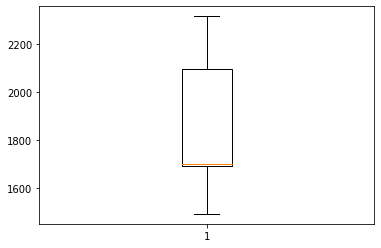

In [35]:
# summarize scores: n_diff = 0, SIN DIFFERENCING, apply_log = True
summarize_scores('LSTM with bayesian hiperametrization + walk-forward', scores)

## NOTAS sobre time series models:
#### Checkear posible estacionalidad con medias, varianzas y/o dickey fulller test
#### Aplicar primero (si lo hay) power transforms y luego el differencing
#### Probar ARIMA vs LSTM, CNN... 
#### En este ejemplo, LSTM está funcionando mejor sin aplicar logs ni differencing
#### Piensa que son pocos para una red neuronal (en principio), probar con datasets más tochos